In [1]:
%load_ext autoreload
%autoreload 2

In [166]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import regex as re
import time
import random

In [167]:
# Manually compiled this dataset of the sets relevant to this analysis
CONFIG = [
  {
    'set_name': 'Modern Masters 2017',
    'set_code': 'MM3',
    'URL': 'https://www.mtggoldfish.com/sets/Modern+Masters+2017+Edition/Main+Set#paper',
    'release_date': '2017-03-17',
    'set_type': 'reprint'
  },
  {
    'set_name': 'Ultimate Masters',
    'set_code': 'UMA',
    'URL': 'https://www.mtggoldfish.com/sets/Ultimate+Masters/Main+Set#paper',
    'release_date': '2018-12-07',
    'set_type': 'reprint'
  },
  {
    'set_name': 'Throne of Eldraine',
    'set_code': 'ELD',
    'URL': 'https://www.mtggoldfish.com/sets/Throne+of+Eldraine/Main+Set#paper',
    'release_date': '2019-10-04',
    'set_type': 'premiere'
  },
  {
    'set_name': 'Ikoria: Lair of Behemoths',
    'set_code': 'IKO',
    'URL': 'https://www.mtggoldfish.com/sets/Ikoria+Lair+of+Behemoths/Main+Set#paper',
    'release_date': '2020-05-05',
    'set_type': 'premiere'
  },
  {
    'set_name': 'Core 2021',
    'set_code': 'M21',
    'URL': 'https://www.mtggoldfish.com/sets/Core+Set+2021/Main+Set#paper',
    'release_date': '2020-07-03',
    'set_type': 'premiere'
  },
  {
    'set_name': 'Double Masters',
    'set_code': '2XM',
    'URL': 'https://www.mtggoldfish.com/sets/Double+Masters/Main+Set#paper',
    'release_date': '2020-08-07',
    'set_type': 'reprint'
  },
  {
    'set_name': 'Zendikar Rising',
    'set_code': 'ZNR',
    'URL': 'https://www.mtggoldfish.com/sets/Zendikar+Rising/Main+Set#paper',
    'release_date': '2020-09-25',
    'set_type': 'premiere'
  },
  {
    'set_name': 'Kaldheim',
    'set_code': 'KHM',
    'URL': 'https://www.mtggoldfish.com/sets/Kaldheim/Main+Set#paper',
    'release_date': '2021-01-29',
    'set_type': 'premiere'
  },
  {
    'set_name': 'Time Spiral Remastered',
    'set_code': 'TSR',
    'URL': 'https://www.mtggoldfish.com/sets/Time+Spiral+Remastered/Main+Set#paper',
    'release_date': '2021-03-01',
    'set_type': 'reprint'
  },
  {
    'set_name': 'Strixhaven: School of Mages',
    'set_code': 'STX',
    'URL': 'https://www.mtggoldfish.com/sets/Strixhaven+School+of+Mages/Main+Set#paper',
    'release_date': '2021-04-23',
    'set_type': 'premiere'
  },
  {
    'set_name': 'Innistrad: Midnight Hunt',
    'set_code': 'MID',
    'URL': 'https://www.mtggoldfish.com/sets/Innistrad+Midnight+Hunt/Main+Set#paper',
    'release_date': '2021-09-24',
    'set_type': 'premiere'
  },
  {
    'set_name': 'Innistrad: Crimson Vow',
    'set_code': 'VOW',
    'URL': 'https://www.mtggoldfish.com/sets/Innistrad+Crimson+Vow/Main+Set#paper',
    'release_date': '2021-11-19',
    'set_type': 'premiere'
  },
  {
    'set_name': 'Kamigawa Neon Dynasty',
    'set_code': 'NEO',
    'URL': 'https://www.mtggoldfish.com/sets/Kamigawa+Neon+Dynasty/Main+Set#paper',
    'release_date': '2022-02-18',
    'set_type': 'premiere'
  },
  {
    'set_name': 'Streets of New Capenna',
    'set_code': 'SNC',
    'URL': 'https://www.mtggoldfish.com/sets/Streets+of+New+Capenna/Main+Set#paper',
    'release_date': '2022-05-06',
    'set_type': 'premiere'
  },
  {
    'set_name': 'Double Masters 2022',
    'set_code': '2X2',
    'URL': 'https://www.mtggoldfish.com/sets/Double+Masters+2022/Main+Set#paper',
    'release_date': '2022-07-08',
    'set_type': 'reprint'
  },
  {
    'set_name': 'Dominaria United',
    'set_code': 'DMU',
    'URL': 'https://www.mtggoldfish.com/sets/Dominaria+United/Main+Set#paper',
    'release_date': '2022-09-09',
    'set_type': 'premiere'
  },
  {
    'set_name': "The Brothers' War",
    'set_code': 'BRO',
    'URL': 'https://www.mtggoldfish.com/sets/The+Brothers+War/Main+Set#paper',
    'release_date': '2022-11-15',
    'set_type': 'premiere'
  }
]
df_config = pd.DataFrame.from_records(CONFIG)

In [168]:
# regexp to pull out the javascript with the price data
raw_data_re = re.compile(r'(?<=\$\("\.price-sources-paper"\)\.toggle\(true\);\s+var d = "Date,.+";\s+)([^g]+)')

# regexp to pull out the dates and prices
dates_re = re.compile(r'(\d{4}-\d{2}-\d{2})')
price_re = re.compile(r'(\d+\.\d+)')

def get_data(url):
    """
    Scrape the URL for the price data

    :param url: URL to scrape
    :return: tuple of dates and prices
    """
    r = requests.get(url)
    soup = BeautifulSoup(r.text, "html.parser")
    scripts = soup.find_all("script", type="text/javascript", string=re.compile(r'var d = "Date'))

    if len(scripts) > 1:
        raise Exception('uh oh, more than one script found')
    script = scripts[0]

    raw_match = raw_data_re.findall(script.text)
    if len(raw_match) > 1:
        raise Exception('uh oh, more than one raw dataset found')
    raw_match = raw_match[0]

    dates = dates_re.findall(raw_match)
    prices = price_re.findall(raw_match)
    prices = [float(price) for price in prices]

    return dates, prices

In [169]:
# Process all the sets in the CONFIG
df = []
for set in CONFIG:
    print(f"processing set_code: {set['set_code']}, set_name: {set['set_name']}")
    dates, prices = get_data(set['URL'])
    temp_df = pd.DataFrame({'date': dates, 'price': prices})
    temp_df['set_name'] = set['set_name']
    temp_df['set_code'] = set['set_code']
    df.append(temp_df)

    # sleep for a couple of seconds to prevente getting blocked
    sleep_time = random.randint(2, 4)
    time.sleep(sleep_time)

df = pd.concat(df)
df['date'] = pd.to_datetime(df['date'])

processing set_code: MM3, set_name: Modern Masters 2017
processing set_code: UMA, set_name: Ultimate Masters
processing set_code: ELD, set_name: Throne of Eldraine
processing set_code: IKO, set_name: Ikoria: Lair of Behemoths
processing set_code: M21, set_name: Core 2021
processing set_code: 2XM, set_name: Double Masters
processing set_code: ZNR, set_name: Zendikar Rising
processing set_code: KHM, set_name: Kaldheim
processing set_code: TSR, set_name: Time Spiral Remastered
processing set_code: STX, set_name: Strixhaven: School of Mages
processing set_code: MID, set_name: Innistrad: Midnight Hunt
processing set_code: VOW, set_name: Innistrad: Crimson Vow
processing set_code: NEO, set_name: Kamigawa Neon Dynasty
processing set_code: SNC, set_name: Streets of New Capenna
processing set_code: 2X2, set_name: Double Masters 2022
processing set_code: DMU, set_name: Dominaria United
processing set_code: BRO, set_name: The Brothers' War


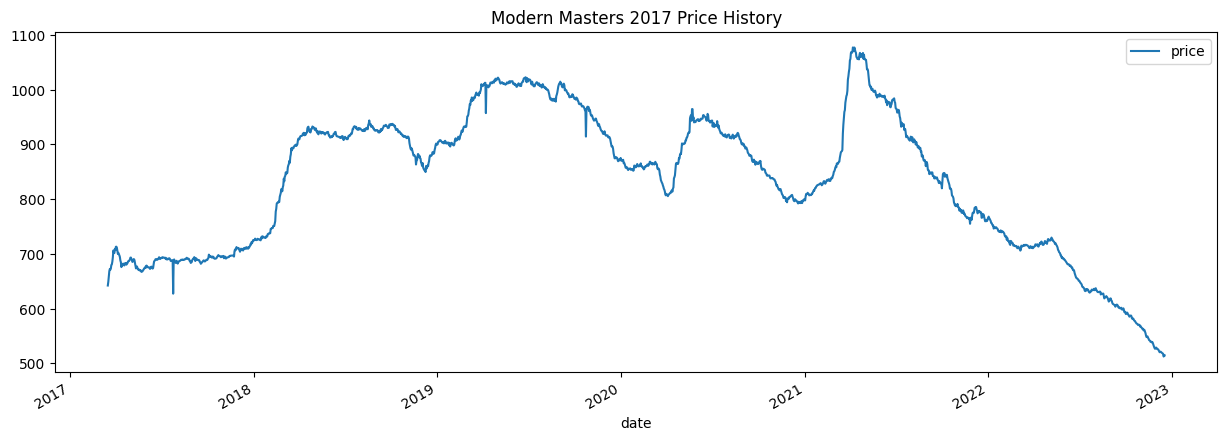

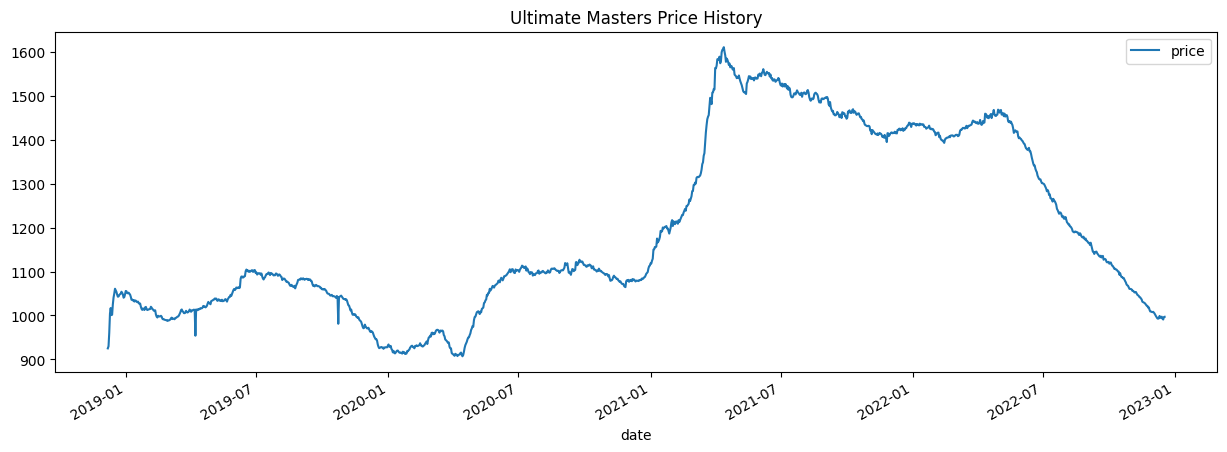

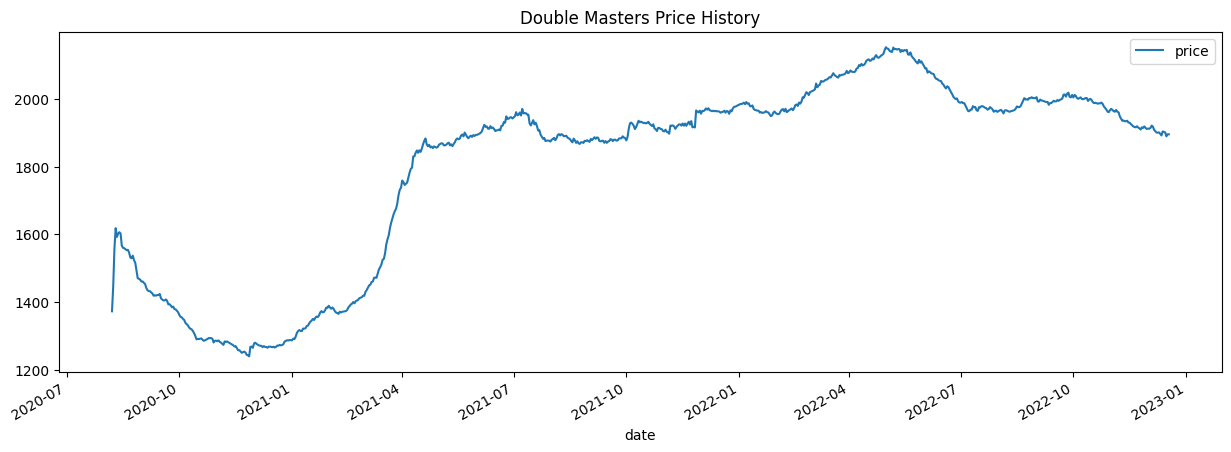

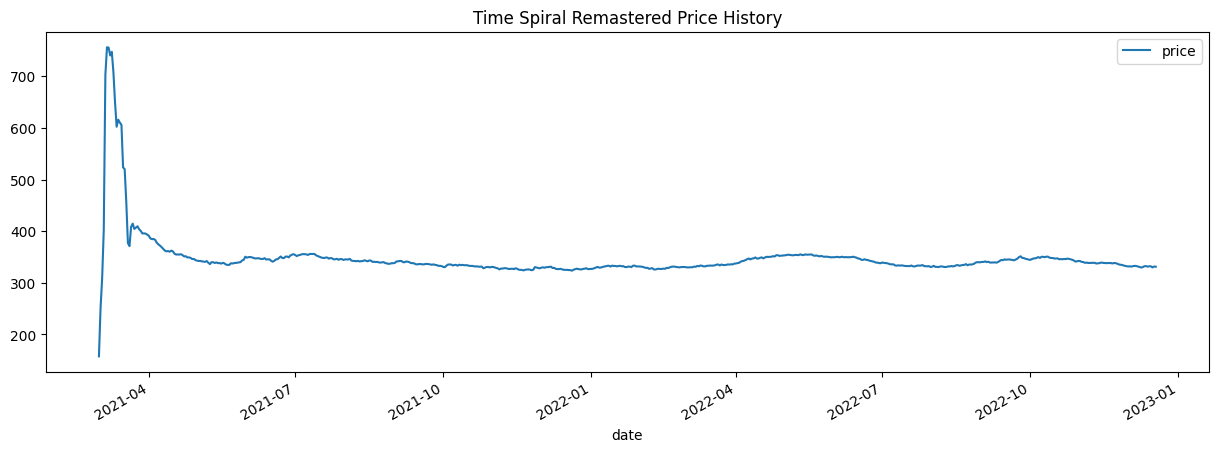

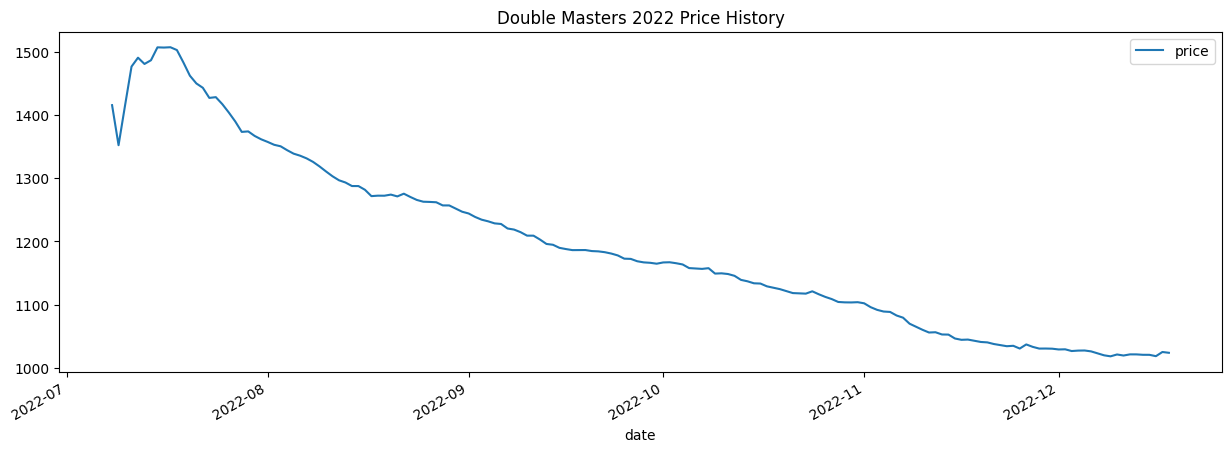

In [174]:
# Plotting all the reprint sets
for set in CONFIG:
    if (set['set_type'] == 'reprint'):
        df[(df['date'] >= set['release_date']) & (df['set_code'] == set['set_code'])].plot(x='date', y='price', title=f"{set['set_name']} Price History", figsize=(15, 5))

In [ ]:
# Plotting all the premiere sets
for set in CONFIG:
    if (set['set_type'] == 'premiere'):
        df[(df['date'] >= set['release_date']) & (df['set_code'] == set['set_code'])].plot(x='date', y='price', title=f"{set['set_name']} Price History", figsize=(15, 5))